In [1]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333, 
                            allow_growth = True, 
                            visible_device_list = "2,3")
config=tf.ConfigProto(gpu_options=gpu_options)

print(config.gpu_options.per_process_gpu_memory_fraction)
print(config.gpu_options.visible_device_list)

/Users/mustafamuratarat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.333
2,3


In [2]:
import numpy as np # import numpy for matrix calculation
np.set_printoptions(threshold=np.nan) #print all the rows and columns in numpy array

import pandas as pd
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

import tensorflow as tf
from tensorflow.python.framework import ops
import random as rd                 # import random for randomly choose training and test set
import matplotlib.pyplot as plt     # pyplot used to plot graphs
%matplotlib inline 
from sklearn.metrics import roc_curve, auc
import time
import math
import itertools

In [3]:
def configuration(dictionary):
    keys, values = zip(*dictionary.items())
    config = [dict(zip(keys, v)) for v in itertools.product(*values)]
    return config 

In [4]:
def normalize_data(data): 
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    data = ((data - data_min) / (data_max - data_min)).as_matrix()
    return data

In [5]:
def convertDummy(y, labelNum):
    labelNum = tf.constant(labelNum)
    dummy = tf.one_hot(y, labelNum, axis=1)
    sess = tf.Session(config=config)
    dummy = sess.run(dummy)
    sess.close()
    return dummy

In [6]:
def train_validation_split(x, y, trainSize = 0.8):# randomly choose training and test set
    numObs = x.shape[0]
    train_length = int(trainSize * numObs)
    trainIndex = rd.sample(range(numObs), train_length)
    xTrain = x[trainIndex, :]
    yTrain = y[trainIndex, :]
    valIndex = [x for x in range(numObs) if x not in trainIndex]
    xVal = x[valIndex, :]
    yVal = y[valIndex, :]
    return xTrain, yTrain, xVal, yVal

In [7]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    colTrain=len(train.columns)
    colValidate=len(validate.columns)
    colTest=len(test.columns)
    xTrain=train.iloc[:,0:colTrain-1].as_matrix()
    yTrain=train.iloc[:,colTrain-1].as_matrix()
    xVal=validate.iloc[:,0:colValidate-1].as_matrix()
    yVal=validate.iloc[:,colValidate-1].as_matrix()
    xTest=test.iloc[:,0:colTest-1].as_matrix()
    yTest=test.iloc[:,colTest-1].as_matrix()
    return xTrain, yTrain, xVal, yVal, xTest, yTest

In [8]:
def miniBatch(x, y, batchSize):
    numObs  = x.shape[0]
    batches = []
    batchNum = math.floor(numObs / batchSize)

    for i in range(batchNum - 1):
        xBatch = x[i * batchSize:(i + 1) * batchSize, :]
        yBatch = y[i * batchSize:(i + 1) * batchSize, :]
        batches.append((xBatch, yBatch))
    xBatch = x[batchNum * batchSize:, :]
    yBatch = y[batchNum * batchSize:, :]
    batches.append((xBatch, yBatch))
    return batches

In [9]:
def initializeParams(model): 
    parameters = {}
    L = len(model['layers_config'])
    for l in range(1, L):
        if l == 1:
            parameters['w' + str(l)] = tf.get_variable('w' + str(l), shape=[model['layers_config']['layer' + str(l)], model['layers_config']['input_layer']], initializer=tf.contrib.layers.xavier_initializer())
            parameters['b' + str(l)] = tf.get_variable('b' + str(l), shape=[model['layers_config']['layer' + str(l)], 1],  initializer=tf.zeros_initializer())
        elif l == (L-1):
            parameters['w' + str(l)] = tf.get_variable('w' + str(l), shape=[model['layers_config']['output_layer'], model['layers_config']['layer' + str(l-1)]], initializer=tf.contrib.layers.xavier_initializer())
            parameters['b' + str(l)] = tf.get_variable('b' + str(l), shape=[model['layers_config']['output_layer'], 1],  initializer=tf.zeros_initializer())
        else:
            parameters['w' + str(l)] = tf.get_variable('w' + str(l), shape=[model['layers_config']['layer' + str(l)], model['layers_config']['layer' + str(l-1)]], initializer=tf.contrib.layers.xavier_initializer())
            parameters['b' + str(l)] = tf.get_variable('b' + str(l), shape=[model['layers_config']['layer' + str(l)], 1],  initializer=tf.zeros_initializer())
    return parameters

In [10]:
def forwardPropagate(x, parameters, model):
    L = int(len(parameters) / 2)
    a = x
    for l in range(1, L+1):
        w = parameters['w' + str(l)]
        b = parameters['b' + str(l)]
        z = tf.add(tf.matmul(a, tf.transpose(w)), tf.transpose(b))
        if l != L:
            if model['activation_functions_config']['layer' + str(l)] == 'tanh':
                f = tf.nn.tanh
            elif model['activation_functions_config']['layer' + str(l)] == 'sigmoid':
                f = tf.nn.sigmoid
            elif model['activation_functions_config']['layer' + str(l)] == 'relu':
                f = tf.nn.relu
            a = f(z)
    return z

In [11]:
def optimizer_opt(model):
    if model['optimizer'] == 'GradientDescentOptimizer':
        g = tf.train.GradientDescentOptimizer
    elif model['optimizer'] == 'AdamOptimizer':
        g = tf.train.AdamOptimizer
    elif model['optimizer'] == 'AdagradOptimizer':
        g = tf.train.AdagradOptimizer
    elif model['optimizer'] == 'AdadeltaOptimizer':
        g = tf.train.AdadeltaOptimizer
    elif model['optimizer'] == 'RMSPropOptimizer':
        g= tf.train.RMSPropOptimizer
    elif model['optimizer'] == 'MomentumOptimizer':
        g = tf.train.MomentumOptimizer
    elif model['optimizer'] == 'FtrlOptimizer':
        g = tf.train.FtrlOptimizer
    return str(model['optimizer']), g(model['learningRate'])

In [12]:
def computeCost(logits, labels):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
#https://stackoverflow.com/questions/34240703/whats-the-difference-between-softmax-and-softmax-cross-entropy-with-logits
    return cost

In [13]:
def dnnModel(xTrain, yTrain, xTest, yTest, model):
    ops.reset_default_graph()

    parameters = initializeParams(model)
    xTrain, yTrain, xVal, yVal = train_validation_split(xTrain, yTrain)
    numObs = xTrain.shape[0]
    numParam = xTrain.shape[1]
    numLabel = yTrain.shape[1]
    x = tf.placeholder(tf.float32, [None, numParam])
    y = tf.placeholder(tf.float32, [None, numLabel])
    zL = forwardPropagate(x, parameters, model)
    cost = computeCost(zL, y)
    
    learning_rates = []
    global_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
    step_rate = 100000 # setup your decay rate
    decay_rate = 0.95 # setup your decay step
    learning_rate = tf.train.exponential_decay(model['learningRate'], global_step, step_rate,  decay_rate, staircase=False)
    k, optimizer = optimizer_opt(model)
    trainer= optimizer.minimize(cost, global_step=global_step)
    
    correctPredictions = tf.equal(tf.argmax(zL, axis=1), tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correctPredictions, 'float'))
    prediction = tf.argmax(zL, axis=1)
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())


    with tf.Session(config=config) as sess:
        sess.run(init)

        print('-----------------------------------------------------------------------')
        print("Initialized: Optimizer: {}, Learning Rate: {}, Iteration Number: {}, Batch Size:{}".format(k, model['learningRate'], model['iterations'], model['batchSize']))
        epochCost = model['iterations'] * [0]
        for i in range(model['iterations']):
            miniBatches = miniBatch(xTrain, yTrain, model['batchSize'])
            batchNum = len(miniBatches)
            for batch in miniBatches:
                xBatch = batch[0]
                yBatch = batch[1]
                _, miniBatchCost = sess.run([trainer, cost], feed_dict={x: xBatch, y: yBatch})
                epochCost[i] += miniBatchCost / batchNum
            learning_rates.append(learning_rate.eval(feed_dict={global_step: i}))
            
            if (i + 1) % 100 == 0 or i == 0:
                print("Cost of iteration {}: {:.6} and Learning rate of iteration {}: {:.6}".format(i + 1, epochCost[i], i + 1, learning_rates[i]))
                
        print("Optimization Done!")
        parameters = sess.run(parameters)
        
        ##### Plotting ##### 
        plt.plot(epochCost)
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.title('Learning rate=' + str(model['learningRate']))
        plt.show()

        #it will look linear because I keep step_rate high.
        plt.plot(range(0, model['iterations']), learning_rates)
        plt.show()

        trainAccuracy = sess.run(accuracy, feed_dict={x: xTrain, y: yTrain})
        cvAccuracy = sess.run(accuracy, feed_dict={x: xVal, y: yVal})
        print("Training accuracy: {:.4f}%".format(trainAccuracy * 100))
        print("Validation accuracy: {:.4f}%".format(cvAccuracy * 100))

        
        prediction = sess.run(prediction, feed_dict={x: xTest})
        prediction = np.reshape(prediction, (len(prediction), 1))   
        
        probabilities = sess.run(zL, feed_dict={x: xTest})
        
        labels = tf.Variable(prediction)
        logits = tf.Variable(yTest)
        
        acc, acc_op = tf.metrics.accuracy(labels=labels, predictions=logits)
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run() 
        _,testAccuracy=sess.run([acc,acc_op])
        print("Testing accuracy: {:.4f}%".format(testAccuracy * 100)) 
    return learning_rates, prediction, probabilities, trainAccuracy, cvAccuracy, testAccuracy

In [14]:
import scipy.io as spio

mat = spio.loadmat('data.mat', squeeze_me=True)
X = mat['X'] # array
y = mat['y'] -1 # structure containing an array

In [15]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=None)

In [16]:
ytrain = convertDummy(ytrain, 10)

In [17]:
#tune the activation functions
activation_functions  = {"input_layer" : ['none'], 
                         "layer1" : ['tanh', 'sigmoid'], 
                         "layer2" : ['tanh', 'sigmoid', 'relu'], 
                         "layer3" : ['tanh'],
                         "output_layer" : ['none']}

In [18]:
#tune the number of hidden nodes
layers = {"input_layer" : [Xtrain.shape[1]], 
          "layer1" : [100], 
          "layer2" : [100], 
          "layer3" : [100], 
          "output_layer" : [ytrain.shape[1]]}

In [19]:
#tune the other parameters
config_overrides = {
    'layers_config': [j for j in configuration(layers)],
    'activation_functions_config': [i for i in configuration(activation_functions)],
    'learningRate': [0.1],
    'iterations': [100, 500, 1000],
    'batchSize': [500, 1000, 1024],
    'optimizer': ['GradientDescentOptimizer']
}

In [20]:
#all the possible combinations
model = configuration(config_overrides)

In [21]:
len(model) #different types of model

54

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:500
Cost of iteration 1: 2.18166 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.120596 and Learning rate of iteration 100: 0.0999949
Optimization Done!


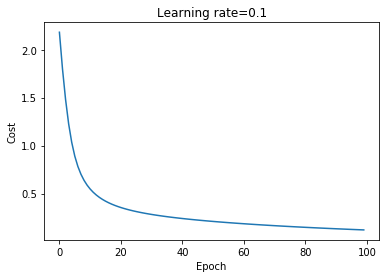

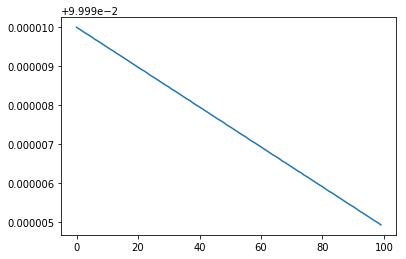

Training accuracy: 95.8582%
Validation accuracy: 90.5970%
Testing accuracy: 89.5758%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1000
Cost of iteration 1: 2.27208 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.248719 and Learning rate of iteration 100: 0.0999949
Optimization Done!


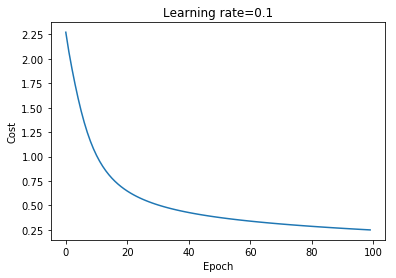

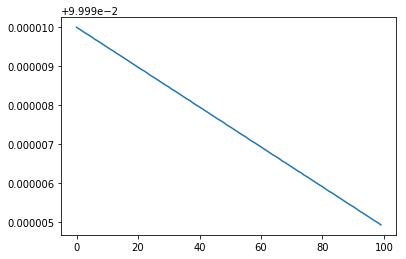

Training accuracy: 92.2015%
Validation accuracy: 90.2985%
Testing accuracy: 88.6061%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1024
Cost of iteration 1: 2.3411 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.224588 and Learning rate of iteration 100: 0.0999949
Optimization Done!


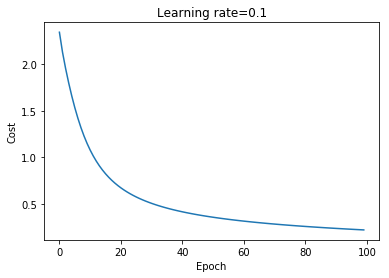

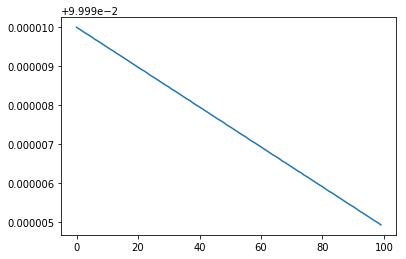

Training accuracy: 92.7612%
Validation accuracy: 88.3582%
Testing accuracy: 89.2121%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:500
Cost of iteration 1: 2.13999 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.118848 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.0431369 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.020306 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0113072 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0072574 and Learning rate of iteration 500: 0.0999744
Optimization Done!


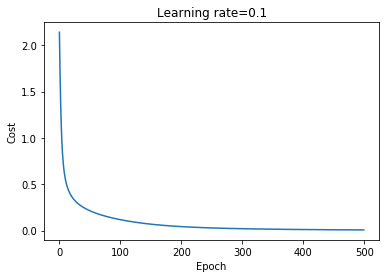

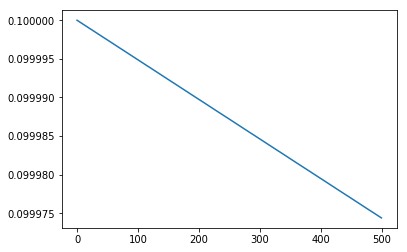

Training accuracy: 98.6194%
Validation accuracy: 91.9403%
Testing accuracy: 89.0909%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1000
Cost of iteration 1: 2.31417 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.222094 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.117844 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0691681 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.042785 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0281985 and Learning rate of iteration 500: 0.0999744
Optimization Done!


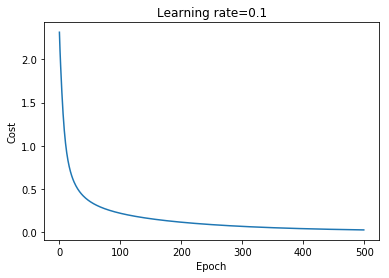

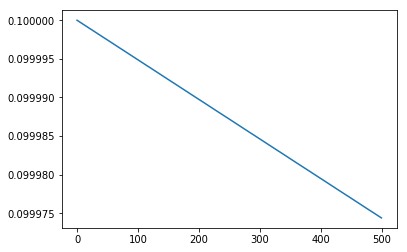

Training accuracy: 96.3433%
Validation accuracy: 90.1493%
Testing accuracy: 89.0909%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1024
Cost of iteration 1: 2.33529 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.213461 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.110064 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0635672 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0392697 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.026084 and Learning rate of iteration 500: 0.0999744
Optimization Done!


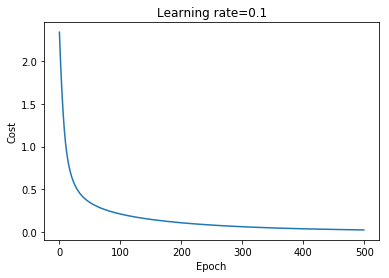

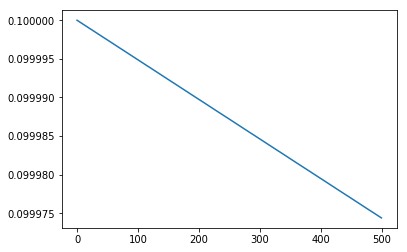

Training accuracy: 95.8209%
Validation accuracy: 91.0448%
Testing accuracy: 89.8788%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:500
Cost of iteration 1: 2.19497 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.114861 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.0439387 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0210149 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0118238 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.00737226 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.00520989 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.00396447 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0031651 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.00261388 

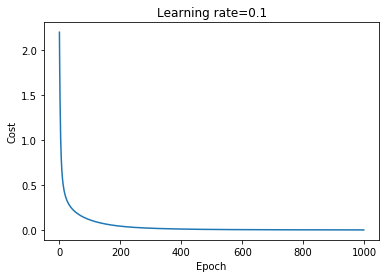

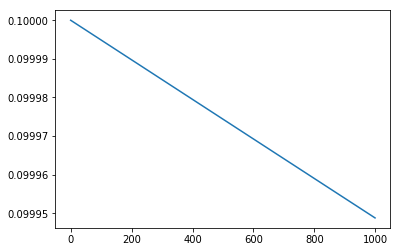

Training accuracy: 98.3582%
Validation accuracy: 90.7463%
Testing accuracy: 89.8788%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1000
Cost of iteration 1: 2.29806 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.226045 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.126386 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0768657 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0491751 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0334027 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.0239467 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0178195 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0136261 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.0107746 and 

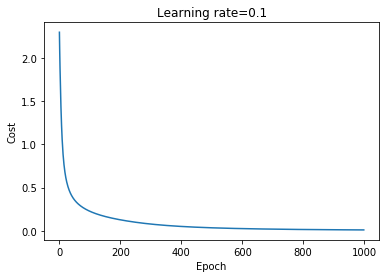

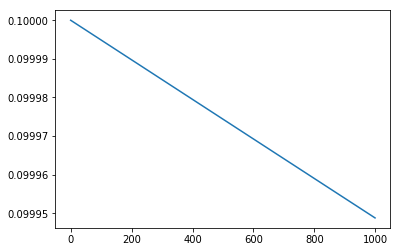

Training accuracy: 96.1194%
Validation accuracy: 90.8955%
Testing accuracy: 88.8485%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1024
Cost of iteration 1: 2.31948 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.235819 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.130958 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0791208 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0496218 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0324765 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.0226033 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0166798 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0129094 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.0103698 and 

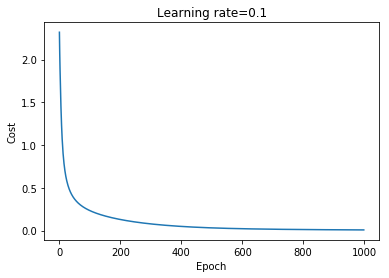

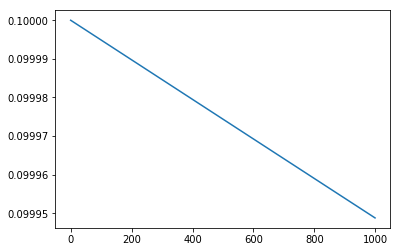

Training accuracy: 96.5299%
Validation accuracy: 90.8955%
Testing accuracy: 89.3333%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:500
Cost of iteration 1: 2.32971 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.276714 and Learning rate of iteration 100: 0.0999949
Optimization Done!


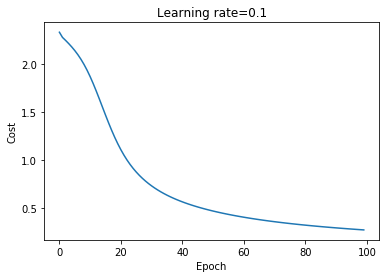

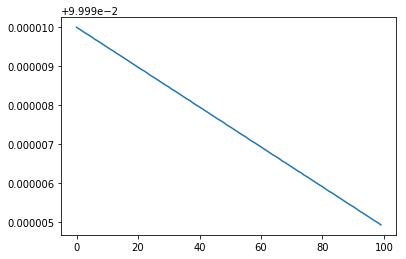

Training accuracy: 92.5000%
Validation accuracy: 88.9552%
Testing accuracy: 89.5151%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1000
Cost of iteration 1: 2.37893 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.576098 and Learning rate of iteration 100: 0.0999949
Optimization Done!


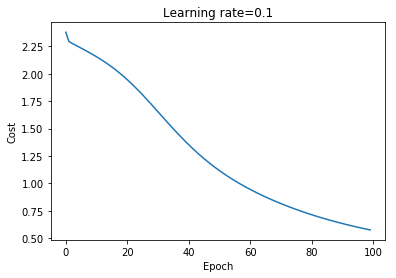

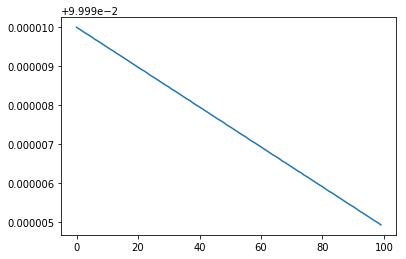

Training accuracy: 86.0821%
Validation accuracy: 84.9254%
Testing accuracy: 84.0606%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1024
Cost of iteration 1: 2.48655 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.528155 and Learning rate of iteration 100: 0.0999949
Optimization Done!


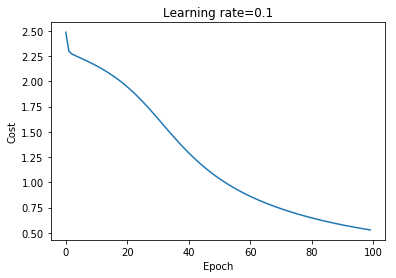

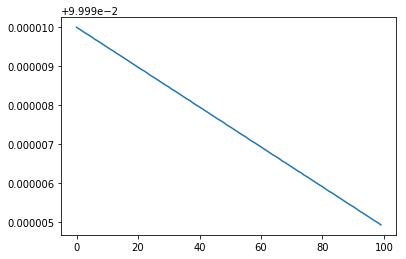

Training accuracy: 87.3134%
Validation accuracy: 84.1791%
Testing accuracy: 84.1818%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:500
Cost of iteration 1: 2.31047 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.265795 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.147169 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0869453 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.050253 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0297804 and Learning rate of iteration 500: 0.0999744
Optimization Done!


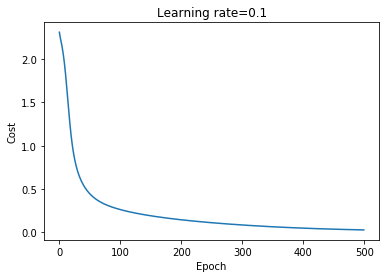

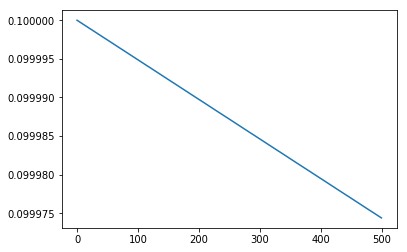

Training accuracy: 98.1343%
Validation accuracy: 91.3433%
Testing accuracy: 89.8788%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1000
Cost of iteration 1: 2.42398 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.572704 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.304139 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.216212 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.163279 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.124978 and Learning rate of iteration 500: 0.0999744
Optimization Done!


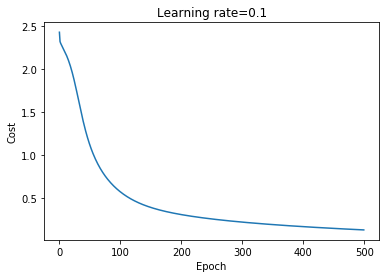

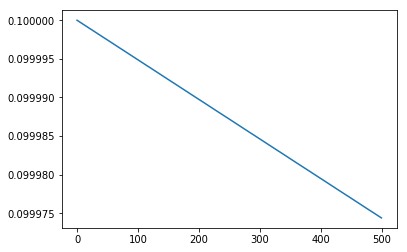

Training accuracy: 94.4030%
Validation accuracy: 89.7015%
Testing accuracy: 89.1515%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1024
Cost of iteration 1: 2.34896 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.587124 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.32869 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.23258 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.173856 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.132034 and Learning rate of iteration 500: 0.0999744
Optimization Done!


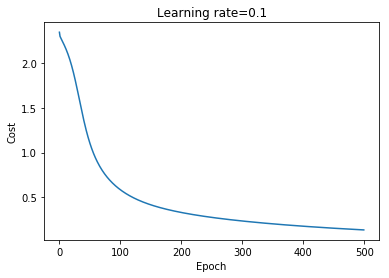

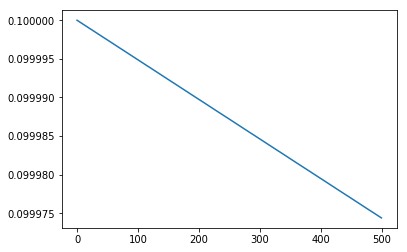

Training accuracy: 94.5895%
Validation accuracy: 89.2537%
Testing accuracy: 89.8788%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:500
Cost of iteration 1: 2.35428 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.281816 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.160883 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0988322 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0595888 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0359802 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.0224281 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0147829 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0105716 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.00803596 and 

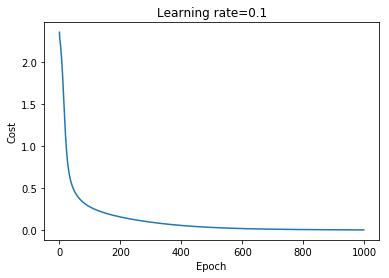

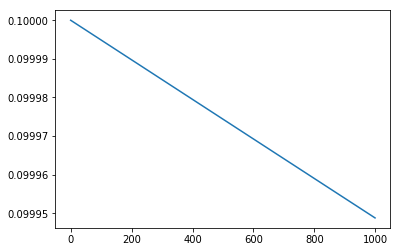

Training accuracy: 98.6194%
Validation accuracy: 91.7910%
Testing accuracy: 90.6667%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1000
Cost of iteration 1: 2.41294 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.568266 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.308602 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.218381 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.161293 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.120236 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.0896066 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0668806 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0505406 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.0389067 and Lea

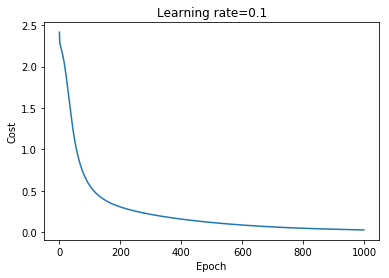

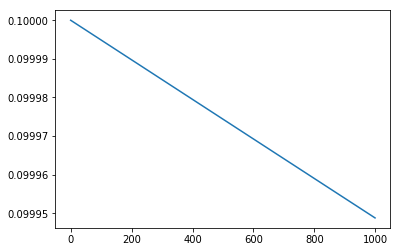

Training accuracy: 96.6045%
Validation accuracy: 90.2985%
Testing accuracy: 89.2727%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1024
Cost of iteration 1: 2.33812 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.532783 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.302005 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.216072 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.164324 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.127904 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.100251 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0786111 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0614779 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.0481592 and Lear

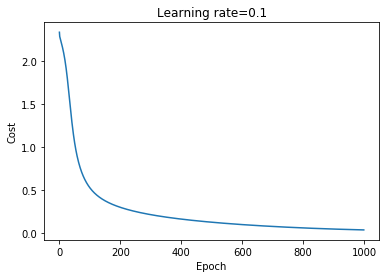

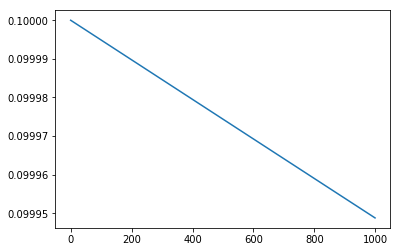

Training accuracy: 95.9701%
Validation accuracy: 92.0896%
Testing accuracy: 88.6061%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:500
Cost of iteration 1: 2.23197 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.0906213 and Learning rate of iteration 100: 0.0999949
Optimization Done!


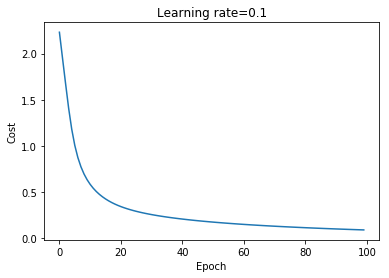

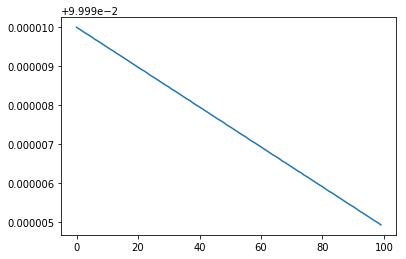

Training accuracy: 96.5672%
Validation accuracy: 92.2388%
Testing accuracy: 91.3333%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1000
Cost of iteration 1: 2.32374 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.200988 and Learning rate of iteration 100: 0.0999949
Optimization Done!


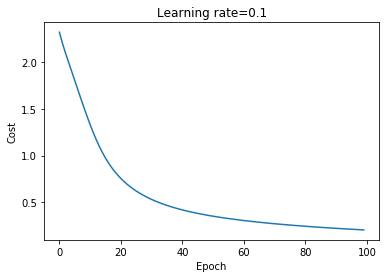

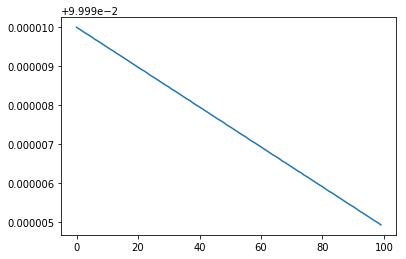

Training accuracy: 93.2463%
Validation accuracy: 89.4030%
Testing accuracy: 89.9394%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1024
Cost of iteration 1: 2.29479 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.219348 and Learning rate of iteration 100: 0.0999949
Optimization Done!


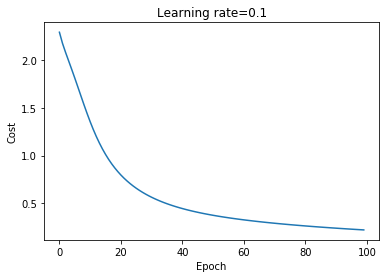

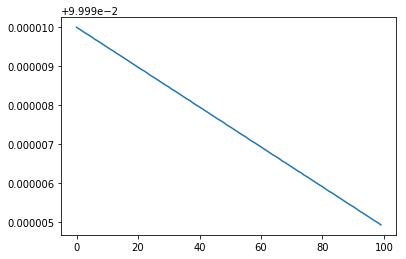

Training accuracy: 92.6119%
Validation accuracy: 90.5970%
Testing accuracy: 88.5455%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:500
Cost of iteration 1: 2.29906 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.0974142 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.0348969 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0163905 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.00919107 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.00604375 and Learning rate of iteration 500: 0.0999744
Optimization Done!


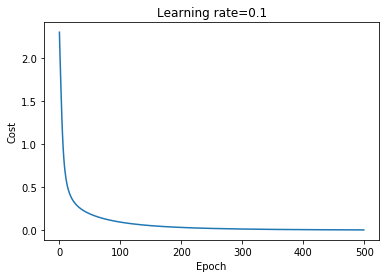

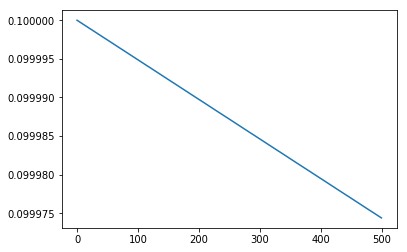

Training accuracy: 98.2836%
Validation accuracy: 91.4925%
Testing accuracy: 91.1515%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1000
Cost of iteration 1: 2.30856 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.228883 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.116485 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0651174 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0384281 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0242834 and Learning rate of iteration 500: 0.0999744
Optimization Done!


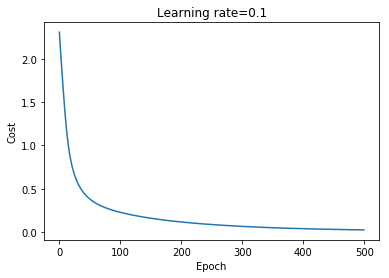

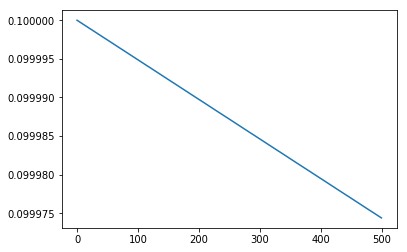

Training accuracy: 96.9776%
Validation accuracy: 90.1493%
Testing accuracy: 89.4545%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1024
Cost of iteration 1: 2.33374 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.226012 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.111575 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0592389 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0344299 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0221366 and Learning rate of iteration 500: 0.0999744
Optimization Done!


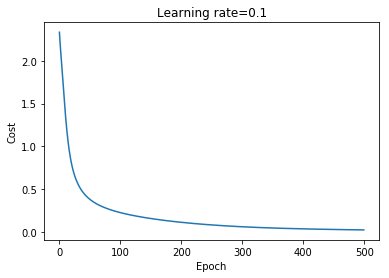

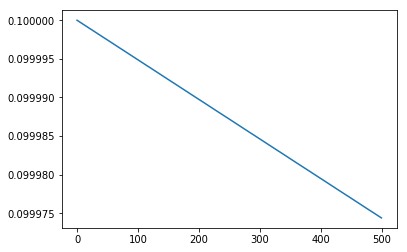

Training accuracy: 95.9328%
Validation accuracy: 90.7463%
Testing accuracy: 89.6970%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:500
Cost of iteration 1: 2.25535 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.106253 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.0399536 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0175045 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.00945658 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.00615521 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.00445 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.00343469 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.00276934 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.00230447 a

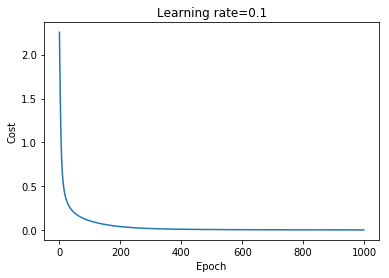

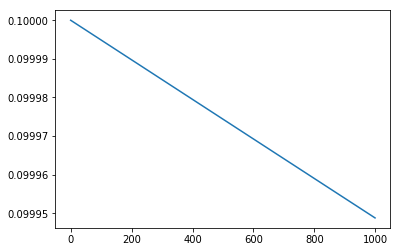

Training accuracy: 98.2090%
Validation accuracy: 91.9403%
Testing accuracy: 91.0909%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1000
Cost of iteration 1: 2.32208 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.219182 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.102304 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.0542177 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0320091 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0210156 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.0149944 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0113701 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.00901769 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.00739241 an

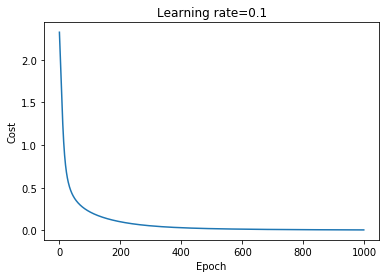

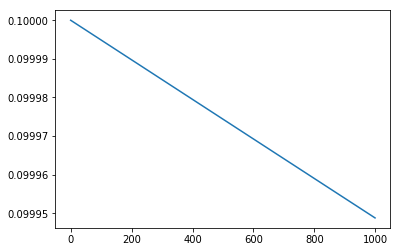

Training accuracy: 97.1269%
Validation accuracy: 91.3433%
Testing accuracy: 90.7273%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1024
Cost of iteration 1: 2.30313 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.222987 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.111594 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.060041 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0348287 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0221467 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.0154948 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0116129 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.00913284 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.00743972 and

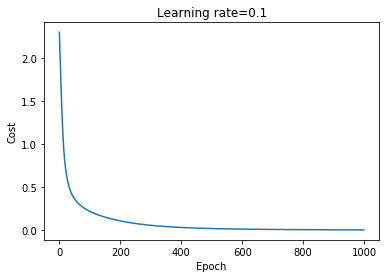

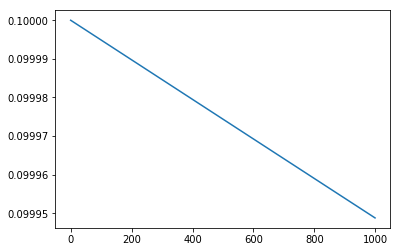

Training accuracy: 97.0149%
Validation accuracy: 90.4478%
Testing accuracy: 90.0606%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:500
Cost of iteration 1: 2.3013 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.268213 and Learning rate of iteration 100: 0.0999949
Optimization Done!


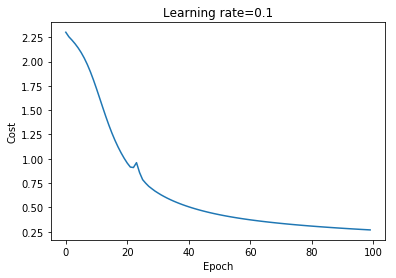

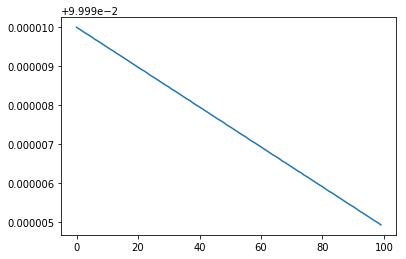

Training accuracy: 92.4627%
Validation accuracy: 89.1045%
Testing accuracy: 88.4242%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1000
Cost of iteration 1: 2.34126 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.472591 and Learning rate of iteration 100: 0.0999949
Optimization Done!


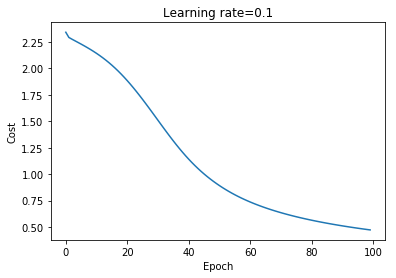

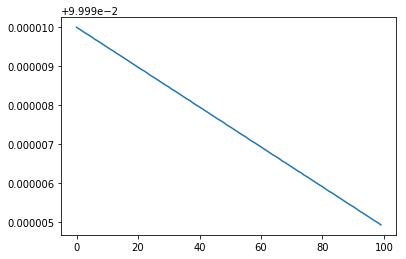

Training accuracy: 87.2015%
Validation accuracy: 86.4179%
Testing accuracy: 83.8788%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1024
Cost of iteration 1: 2.362 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.490906 and Learning rate of iteration 100: 0.0999949
Optimization Done!


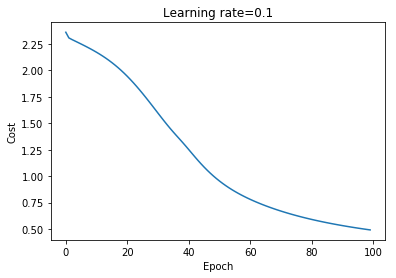

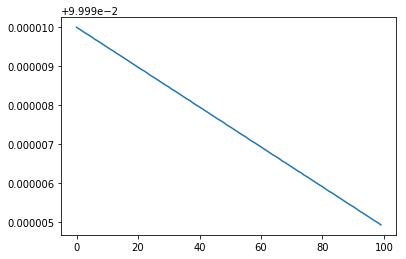

Training accuracy: 87.0896%
Validation accuracy: 87.7612%
Testing accuracy: 84.4849%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:500
Cost of iteration 1: 2.34973 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.260118 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.155618 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.103071 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0691615 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0461108 and Learning rate of iteration 500: 0.0999744
Optimization Done!


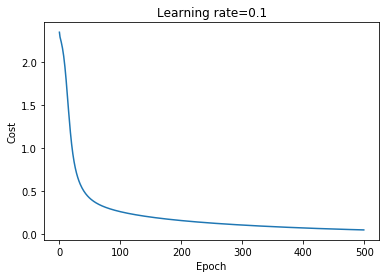

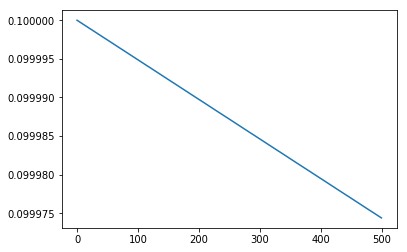

Training accuracy: 97.3507%
Validation accuracy: 90.0000%
Testing accuracy: 89.5758%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1000
Cost of iteration 1: 2.35327 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.47536 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.275933 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.201242 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.154783 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.121826 and Learning rate of iteration 500: 0.0999744
Optimization Done!


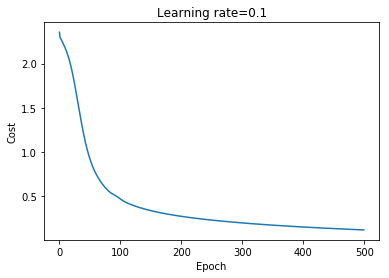

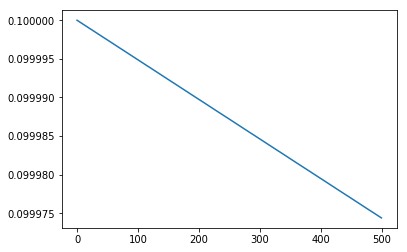

Training accuracy: 94.0672%
Validation accuracy: 88.5075%
Testing accuracy: 88.8485%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1024
Cost of iteration 1: 2.41385 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.501758 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.298134 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.21914 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.167695 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.130708 and Learning rate of iteration 500: 0.0999744
Optimization Done!


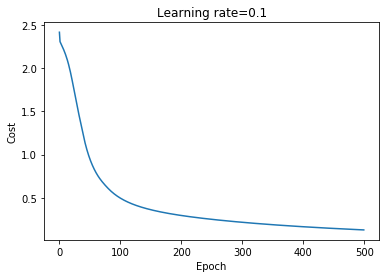

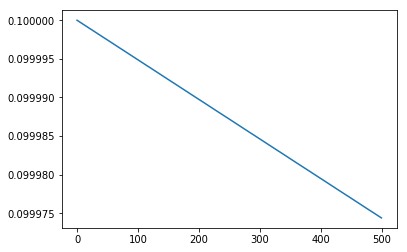

Training accuracy: 93.4702%
Validation accuracy: 90.5970%
Testing accuracy: 88.7879%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:500
Cost of iteration 1: 2.33324 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.263312 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.168823 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.116539 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0815306 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0569256 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.0399946 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0287523 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0211585 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.0159885 and Le

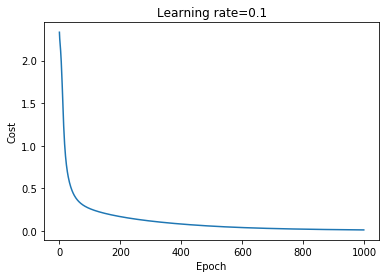

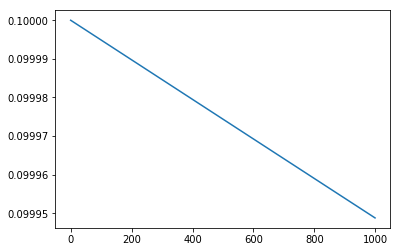

Training accuracy: 98.4328%
Validation accuracy: 88.2090%
Testing accuracy: 88.8485%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1000
Cost of iteration 1: 2.37337 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.510185 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.309201 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.233705 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.1845 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.147508 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.11772 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.093361 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0736602 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.058172 and Learning 

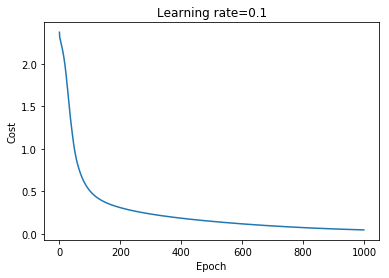

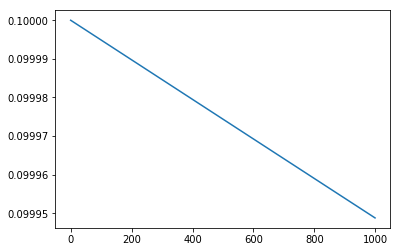

Training accuracy: 95.7836%
Validation accuracy: 90.8955%
Testing accuracy: 88.3636%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1024
Cost of iteration 1: 2.38665 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.465078 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.266517 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.196615 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.153585 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.122697 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.0990254 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0803428 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0653612 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.0532816 and Lea

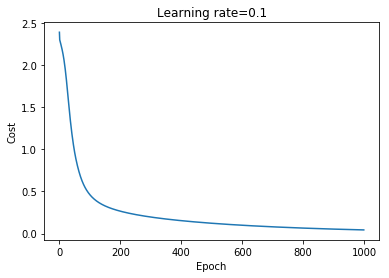

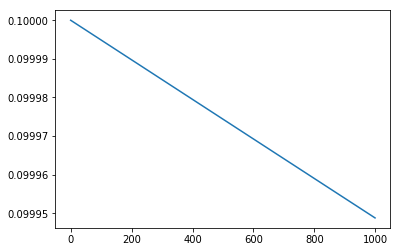

Training accuracy: 95.9701%
Validation accuracy: 87.3134%
Testing accuracy: 88.6667%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:500
Cost of iteration 1: 2.34497 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.790327 and Learning rate of iteration 100: 0.0999949
Optimization Done!


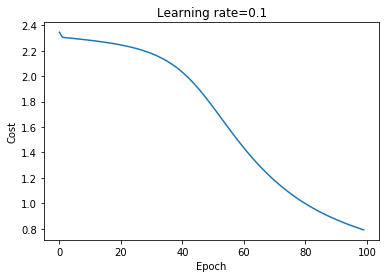

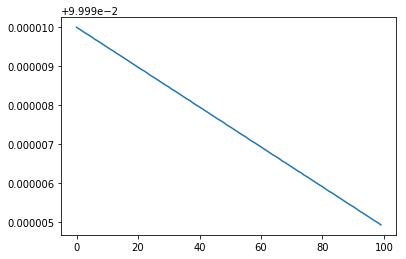

Training accuracy: 75.7090%
Validation accuracy: 75.9701%
Testing accuracy: 73.1515%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1000
Cost of iteration 1: 2.38608 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 2.05314 and Learning rate of iteration 100: 0.0999949
Optimization Done!


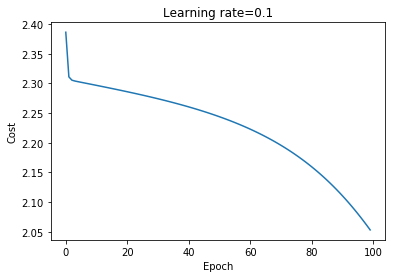

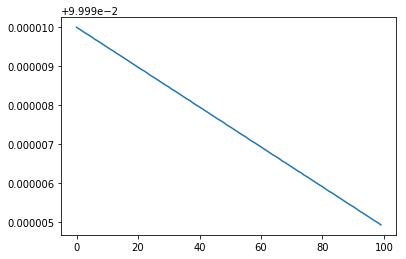

Training accuracy: 41.1940%
Validation accuracy: 38.8060%
Testing accuracy: 36.7879%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1024
Cost of iteration 1: 2.38524 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 2.10111 and Learning rate of iteration 100: 0.0999949
Optimization Done!


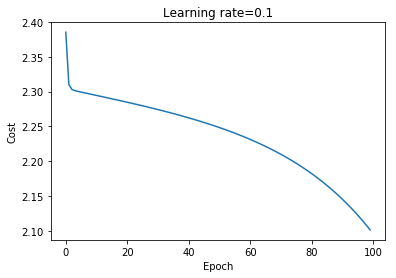

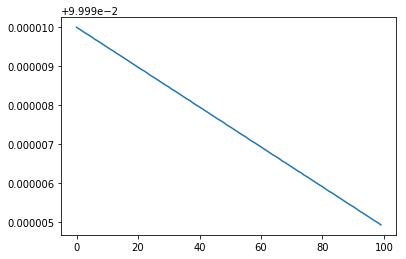

Training accuracy: 41.9030%
Validation accuracy: 40.4478%
Testing accuracy: 37.8788%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:500
Cost of iteration 1: 2.37213 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.782006 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.361747 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.251582 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.198018 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.160274 and Learning rate of iteration 500: 0.0999744
Optimization Done!


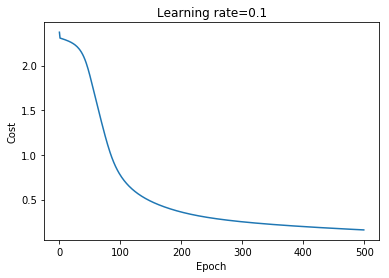

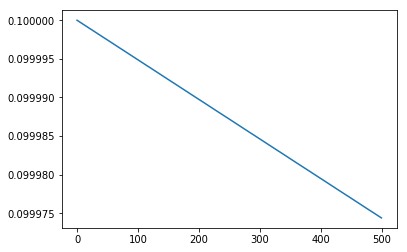

Training accuracy: 94.3284%
Validation accuracy: 90.1493%
Testing accuracy: 89.5151%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1000
Cost of iteration 1: 2.37659 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 2.02842 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 1.01658 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.58752 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.447359 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.36838 and Learning rate of iteration 500: 0.0999744
Optimization Done!


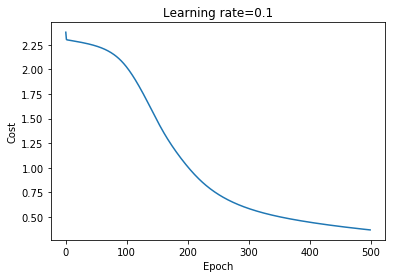

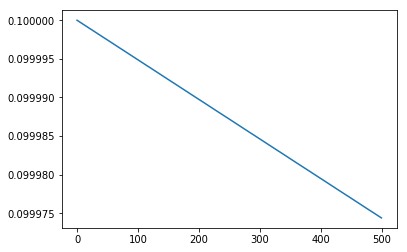

Training accuracy: 88.5821%
Validation accuracy: 85.6716%
Testing accuracy: 85.0909%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1024
Cost of iteration 1: 2.41729 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 2.09187 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 1.02568 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.573926 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.422594 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.343267 and Learning rate of iteration 500: 0.0999744
Optimization Done!


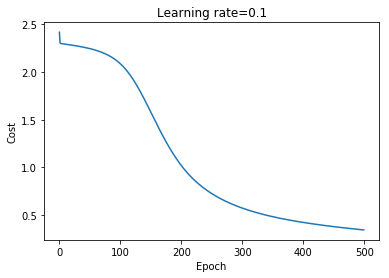

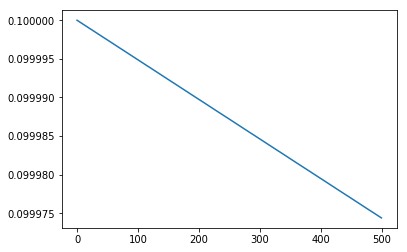

Training accuracy: 89.3657%
Validation accuracy: 86.2687%
Testing accuracy: 85.3333%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:500
Cost of iteration 1: 2.36007 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.78356 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.395174 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.286722 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.228283 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.18489 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.149255 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.119266 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0937914 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.0723019 and Learning

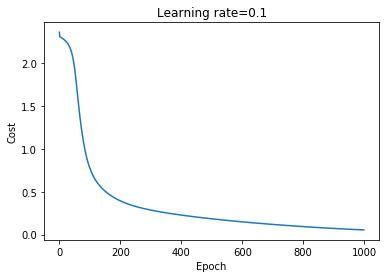

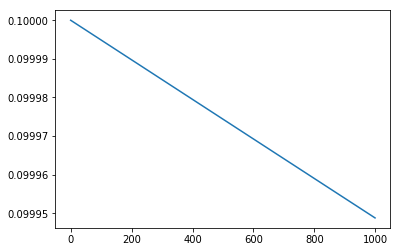

Training accuracy: 96.9403%
Validation accuracy: 91.1940%
Testing accuracy: 89.8182%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1000
Cost of iteration 1: 2.43364 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 2.14924 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 1.12208 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.634948 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.446248 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.354692 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.29922 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.261467 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.232932 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.209469 and Learning r

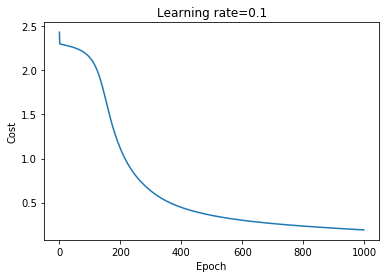

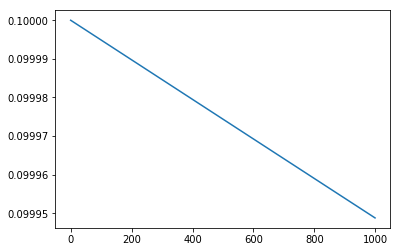

Training accuracy: 92.2388%
Validation accuracy: 91.3433%
Testing accuracy: 88.1818%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1024
Cost of iteration 1: 2.39873 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 2.03287 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.951798 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.569653 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.405777 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.321938 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.269901 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.233045 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.204349 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.180469 and Learning

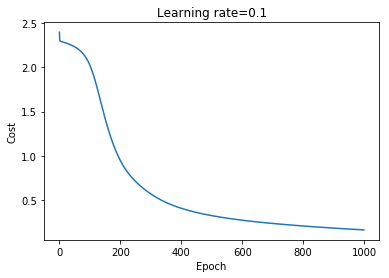

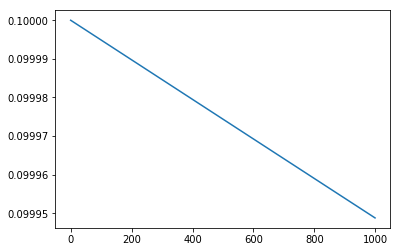

Training accuracy: 93.2836%
Validation accuracy: 88.9552%
Testing accuracy: 88.3636%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:500
Cost of iteration 1: 2.31145 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.282677 and Learning rate of iteration 100: 0.0999949
Optimization Done!


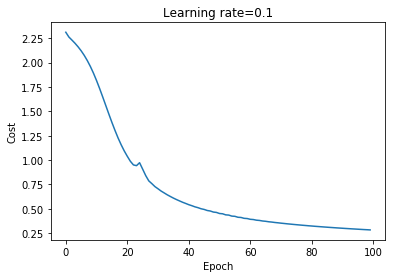

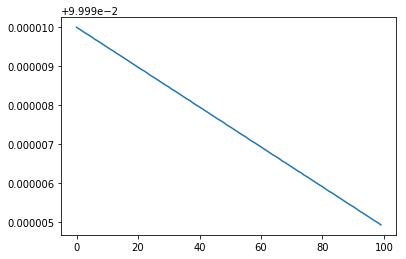

Training accuracy: 91.6045%
Validation accuracy: 88.6567%
Testing accuracy: 88.3636%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1000
Cost of iteration 1: 2.38919 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.573896 and Learning rate of iteration 100: 0.0999949
Optimization Done!


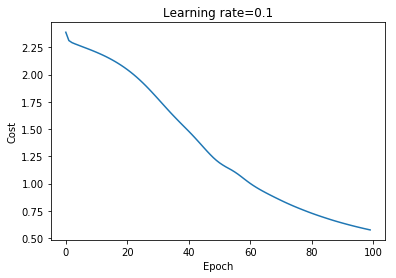

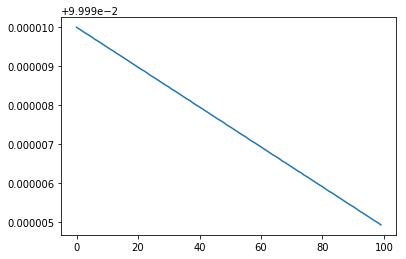

Training accuracy: 85.1493%
Validation accuracy: 86.1194%
Testing accuracy: 82.4848%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 100, Batch Size:1024
Cost of iteration 1: 2.36731 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.574482 and Learning rate of iteration 100: 0.0999949
Optimization Done!


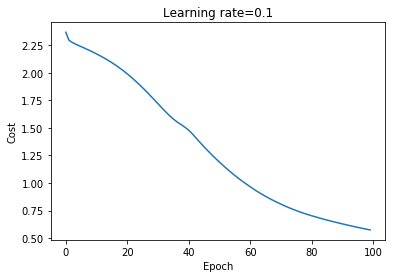

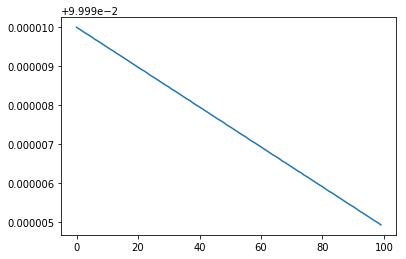

Training accuracy: 84.2164%
Validation accuracy: 83.4328%
Testing accuracy: 81.4545%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:500
Cost of iteration 1: 2.32313 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.292869 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.169905 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.107077 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0679751 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0432475 and Learning rate of iteration 500: 0.0999744
Optimization Done!


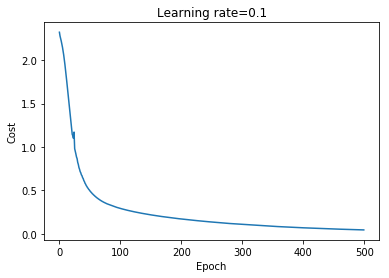

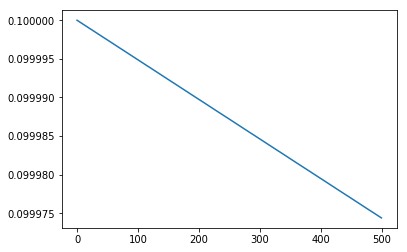

Training accuracy: 97.8358%
Validation accuracy: 89.5522%
Testing accuracy: 89.4545%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1000
Cost of iteration 1: 2.32468 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.575624 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.33848 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.258273 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.204976 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.166632 and Learning rate of iteration 500: 0.0999744
Optimization Done!


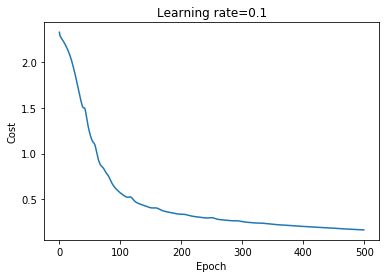

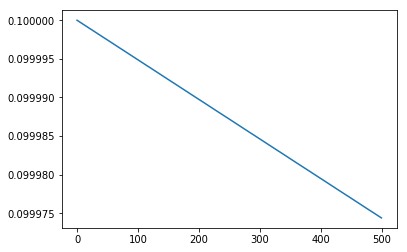

Training accuracy: 94.3657%
Validation accuracy: 88.5075%
Testing accuracy: 88.7879%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 500, Batch Size:1024
Cost of iteration 1: 2.34144 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.548806 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.30691 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.219593 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.164948 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.126515 and Learning rate of iteration 500: 0.0999744
Optimization Done!


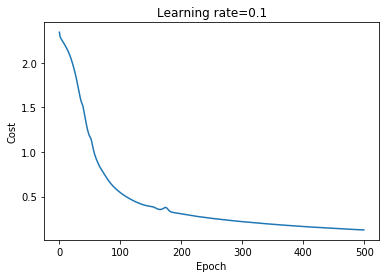

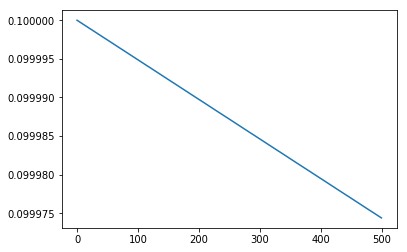

Training accuracy: 94.3657%
Validation accuracy: 89.4030%
Testing accuracy: 88.8485%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:500
Cost of iteration 1: 2.34601 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.296927 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.177197 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.119007 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.0801823 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0525493 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.0341427 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0228025 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0161267 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.0120756 and Le

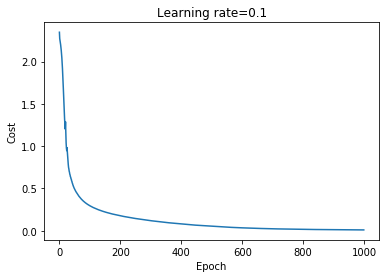

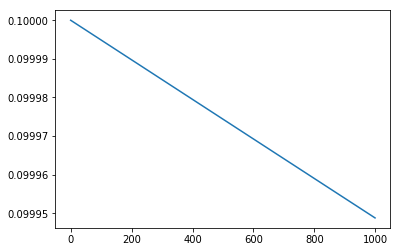

Training accuracy: 98.5075%
Validation accuracy: 89.8507%
Testing accuracy: 89.4545%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1000
Cost of iteration 1: 2.36169 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.636146 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.342768 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.251308 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.198904 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.160353 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.130169 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.105868 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.086471 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.0710224 and Learni

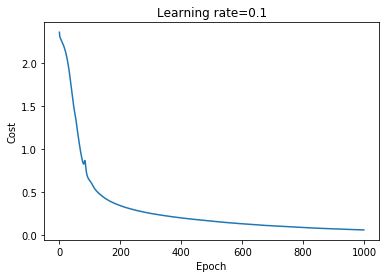

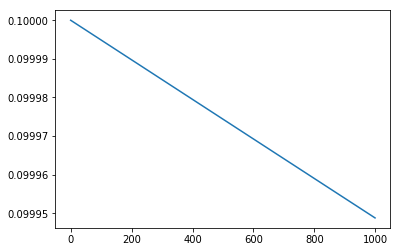

Training accuracy: 95.5597%
Validation accuracy: 90.1493%
Testing accuracy: 89.0909%
-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 1000, Batch Size:1024
Cost of iteration 1: 2.32709 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.553038 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.293809 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.205833 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.158871 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.127881 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.104914 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0866949 and Learning rate of iteration 700: 0.0999642
Cost of iteration 800: 0.0717096 and Learning rate of iteration 800: 0.099959
Cost of iteration 900: 0.0592795 and Lear

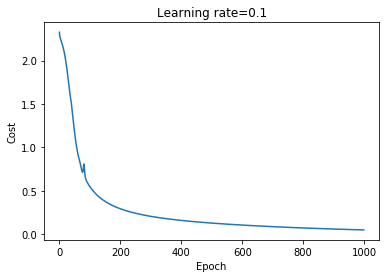

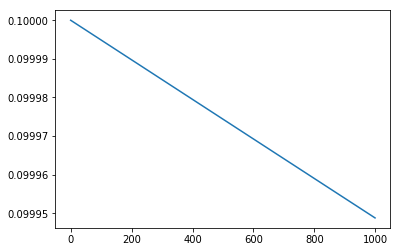

Training accuracy: 95.0373%
Validation accuracy: 88.6567%
Testing accuracy: 88.8485%


In [22]:
result = []
for i in range(0,len(model)):
    learning_rates, prediction, probs, trainingAccuracy, cvAccuracy, testAccuracy = dnnModel(Xtrain, ytrain, Xtest, ytest, model[i])
    result.append((model[i], trainingAccuracy, cvAccuracy, testAccuracy))

In [25]:
#The best model giving high training accuracy
max(result, key=lambda x: x[1])

({'activation_functions_config': {'input_layer': 'none',
   'layer1': 'tanh',
   'layer2': 'tanh',
   'layer3': 'tanh',
   'output_layer': 'none'},
  'batchSize': 500,
  'iterations': 500,
  'layers_config': {'input_layer': 400,
   'layer1': 100,
   'layer2': 100,
   'layer3': 100,
   'output_layer': 10},
  'learningRate': 0.1,
  'optimizer': 'GradientDescentOptimizer'},
 0.986194,
 0.91940296,
 0.8909091)